# LSA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

#### Read in the central bank data
* drop undated papers
* only keep papers after 1999
* create a column with the central bank identifier

In [2]:
all_cb_data  = pd.read_csv("data.csv")
all_cb_data  = all_cb_data[all_cb_data.Year != "undated"]
all_cb_data  = all_cb_data[pd.to_numeric(all_cb_data.Year) > 1999]
all_cb_data.index = range(len(all_cb_data))

# add central bank identifiers
def cb_id(s):
    if 'Australia' in s:
        return 'RBA'
    elif 'US' in s:
        return 'US'
    elif 'European' in s:
        return 'ECB'
    elif 'Japan' in s:
        return 'BoJ'
    elif 'Canada' in s:
        return 'BoC'
    elif 'New Zealand' in s:
        return 'RBNZ'
    elif 'England' in s:
        return 'BoE'
    elif 'Sweden' in s:
        return 'Riksbank'
    elif 'Norges' in s:
        return 'Norges'
        
all_cb_data['Central_Bank'] = all_cb_data.ID.map(cb_id)

len(all_cb_data)

6637

In [3]:
# remove papers where the abstract is not available
all_cb_data = all_cb_data[all_cb_data.Abstract != 'No abstract available']
len(all_cb_data)

6637

#### Read in the academic papers
* Create a combined data frame with all papers

In [4]:
all_aca_data = pd.read_csv("macro_data.csv")
# all_aca_data = all_aca_data[all_aca_data.ID != 'The Quarterly Journal of Economics']
len(all_aca_data)

1981

In [5]:
# remove papers where the abstract is not available
all_aca_data = all_aca_data[all_aca_data.Abstract != 'No abstract is available for this item.']
len(all_aca_data)

1566

In [6]:
abs_raw   = all_cb_data.Abstract.append(all_aca_data.Abstract, ignore_index=True)

#### Preprocessing function

In [7]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create English stop words list
en_stop = set(stopwords.words('english'))
# add context-specific stop words to list
en_stop = en_stop.union(["per","cent","one","two","three","four","five","six","seven","eight","nine","use",
                         "also","paper","results","evidence","suggests","implies","indicates","jel","find",
                         "finding",'hypothesis',"classification","area","effect","may","could","might"
                         ,"canada","canadian","australia","australian","japan","japanese","new zealand",
                         "swedish","sweden","norway","norwegian"])
    
def preprocess(s):
    
    # make lower case
    s = s.lower()
    
    # remove all numbers
    s = re.sub(r'[0-9]+', '', s)
    
    # create p_stemmer of class PorterStemmer
    p_stemmer  = PorterStemmer()
    
    # create lemmatizer of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tokenize string
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    s = token_pattern.findall(s)

    # remove stop words from tokens
    s = [i for i in s if not i in en_stop]
    
#     # stem words
#     s = [p_stemmer.stem(i) for i in s] 

    # lemmatize words
    s = [lemmatizer.lemmatize(i) for i in s] 
    
    return s

In [8]:
abstracts = abs_raw.map(preprocess)

### Build corpus and reweight by tf-idf

In [9]:
from gensim import corpora
from gensim.models import TfidfModel

# build dictionary using all words
dictionary = corpora.Dictionary(abstracts)
print(dictionary)

# build corpus 
corpus = [dictionary.doc2bow(text) for text in abstracts]

#apply tf-idf
tfidf  = TfidfModel(corpus)  # fit model
corpus = tfidf[corpus]

Dictionary(14479 unique tokens: ['account', 'agreement', 'available', 'bargaining', 'caused']...)


#### Build LSA matrix and index
* Only use academic papers for the index

In [10]:
from gensim import models, similarities
from gensim.test.utils import common_corpus, common_dictionary

lsi        = models.LsiModel(corpus, id2word=dictionary, num_topics=300)
lsi_matrix = lsi[corpus]

# NB: the index should only include academic papers!!
index      = similarities.MatrixSimilarity(lsi[corpus][len(all_cb_data):len(abstracts)])

In [11]:
#NB: the similarities should only be calculated for central bank papers!!

sims = []
for i in range(len(all_cb_data)):
    similarity = index[lsi_matrix[i]] 
    sims.append(sorted(enumerate(similarity), key=lambda item: -item[1])[0:4])

In [12]:
sims_top = []
for x in range(len(sims)):
    sims_top.append([i[0:2] for i in sims[x]][0])
    
sims_ave = []
for x in range(len(sims)):
    sims_top5 = [i[1] for i in sims[x]]
    sims_ave.append(sum(sims_top5) / len(sims_top5)) 

In [13]:
from operator import itemgetter

sorted(sims_top,key=itemgetter(1))[6000]

(317, 0.68625784)

#### Build LSA matrix and index
* Now only use central bank papers for the index

In [14]:
# NB: the index should only include academic papers!!
index_cb      = similarities.MatrixSimilarity(lsi[corpus][0:len(all_cb_data)])

In [15]:
#NB: the similarities should only be calculated for central bank papers!!
sims_cb = []
for i in range(len(all_cb_data)):
    similarity = index_cb[lsi_matrix[i]] 
    sims_cb.append(sorted(enumerate(similarity), key=lambda item: -item[1])[1:5]) #need to start the indexing at 1
                                                                                  #othwise it's a perfect match!

In [16]:
sims_top_cb = []
for x in range(len(sims_cb)):
    sims_top_cb.append([i[0:2] for i in sims_cb[x]][0])
    
sims_ave_cb = []
for x in range(len(sims_cb)):
    sims_top5 = [i[1] for i in sims_cb[x]]
    sims_ave_cb.append(sum(sims_top5) / len(sims_top5)) 

#### Look at an example comparing a CB paper to an academic paper 
* Reported in the Appendix of the paper

In [17]:
print(abs_raw[378],"=",abs_raw[len(all_cb_data)+sims_top[378][0]])

US monetary policy was constrained from 2008 to 2015 by the zero lower bound, during which the Federal Reserve would likely have lowered the federal funds rate further if it were able to. This paper uses industry-level data to examine how growth was affected. Despite the zero bound constraint, industries historically more sensitive to interest rates, such as construction, performed relatively well in comparison to industries not typically affected by monetary policy. Further evidence suggests that unconventional policy lowered the effective stance of policy below zero. = Discussions of monetary policy rules after the 2007–2009 recession highlight the potential ineffectiveness of a central bank's actions when the short-term interest rate under its control is limited by the zero lower bound. This perspective assumes, in a manner consistent with the canonical New Keynesian model, that the quantity of money has no role to play in transmitting a central bank's actions to economic activity. 

In [18]:
sims_top_df                            = pd.DataFrame(sims_top)
sims_top_df["distance_std"]            = (sims_top_df[1]-sims_top_df[1].mean())/sims_top_df[1].std()
sims_top_df['year']                    = all_cb_data.Year
sims_top_df['CB']                      = all_cb_data.Central_Bank
sims_top_df['paper_indicator']         = np.ones(len(sims_top_df))

sims_ave_df                            = pd.DataFrame(sims_ave)
sims_ave_df["distance_std"]            = (sims_ave_df[0]-sims_ave_df[0].mean())/sims_ave_df[0].std()
sims_ave_df['year']                    = all_cb_data.Year
sims_ave_df['CB']                      = all_cb_data.Central_Bank

sims_top_cb_df                         = pd.DataFrame(sims_top_cb)
sims_top_cb_df["distance_std"]         = (sims_top_cb_df[1]-sims_top_cb_df[1].mean())/sims_top_cb_df[1].std()
sims_top_cb_df['year']                 = all_cb_data.Year
sims_top_cb_df['CB']                   = all_cb_data.Central_Bank
sims_top_cb_df['paper_indicator']      = np.zeros(len(sims_top_cb_df))

sims_top_combined                      = sims_top_df.append(sims_top_cb_df)
sims_top_combined.drop(["distance_std"], axis=1)
sims_top_combined["distance_std"]      = (sims_top_combined[1]-sims_top_combined[1].mean())/sims_top_combined[1].std()

#### Save data to csv for Stata modelling
* This is for the diff-in-diff regression

In [19]:
sims_top_combined.to_csv("combined_cosine_to_stata.csv", encoding='utf-8')
sims_top_df.to_csv("cosine_to_stata.csv", encoding='utf-8')

#### Parallel trends assumption

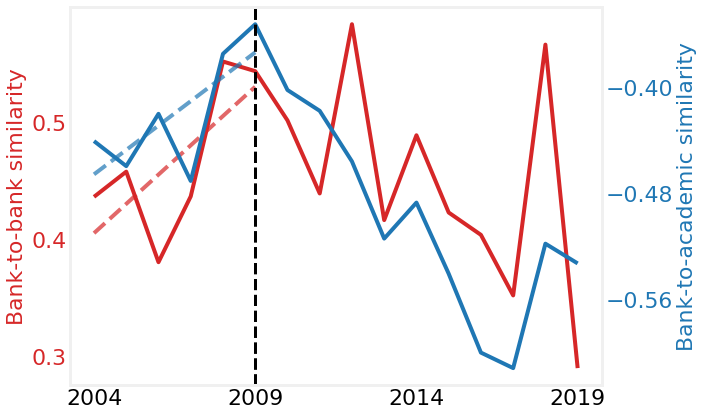

In [20]:
from scipy import stats

cb_top     = pd.DataFrame(sims_top_combined[pd.to_numeric(sims_top_combined.year)>2003])
cb_top     = cb_top[cb_top['paper_indicator'] == 0].groupby(['year']).mean()["distance_std"]

aca_top    = pd.DataFrame(sims_top_combined[pd.to_numeric(sims_top_combined.year)>2003])
aca_top    = aca_top[aca_top['paper_indicator'] == 1].groupby(['year']).mean()["distance_std"]

# Generated linear fit
xi = np.arange(0,6)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,cb_top[0:6])
line_1 = slope*xi+intercept

slope, intercept, r_value, p_value, std_err = stats.linregress(xi,aca_top[0:6])
line_2 = slope*xi+intercept

#Charting
plt.style.use('fivethirtyeight')

fig, ax1 = plt.subplots(figsize=(10,6),facecolor='white')

color = 'tab:red'
ax1.set_ylabel('Bank-to-bank similarity', color=color, fontsize=22)
ax1.plot(cb_top, color=color)
ax1.plot(line_1, '--',alpha=0.7,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_facecolor('white')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 22)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Bank-to-academic similarity', color=color, fontsize=22)  # we already handled the x-label with ax1
ax2.plot(aca_top, color=color)
ax2.plot(line_2, '--',alpha=0.7,color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_facecolor('white')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 22)
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.grid(False)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+5

ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('parallel.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

#### Distance to frontier macro research

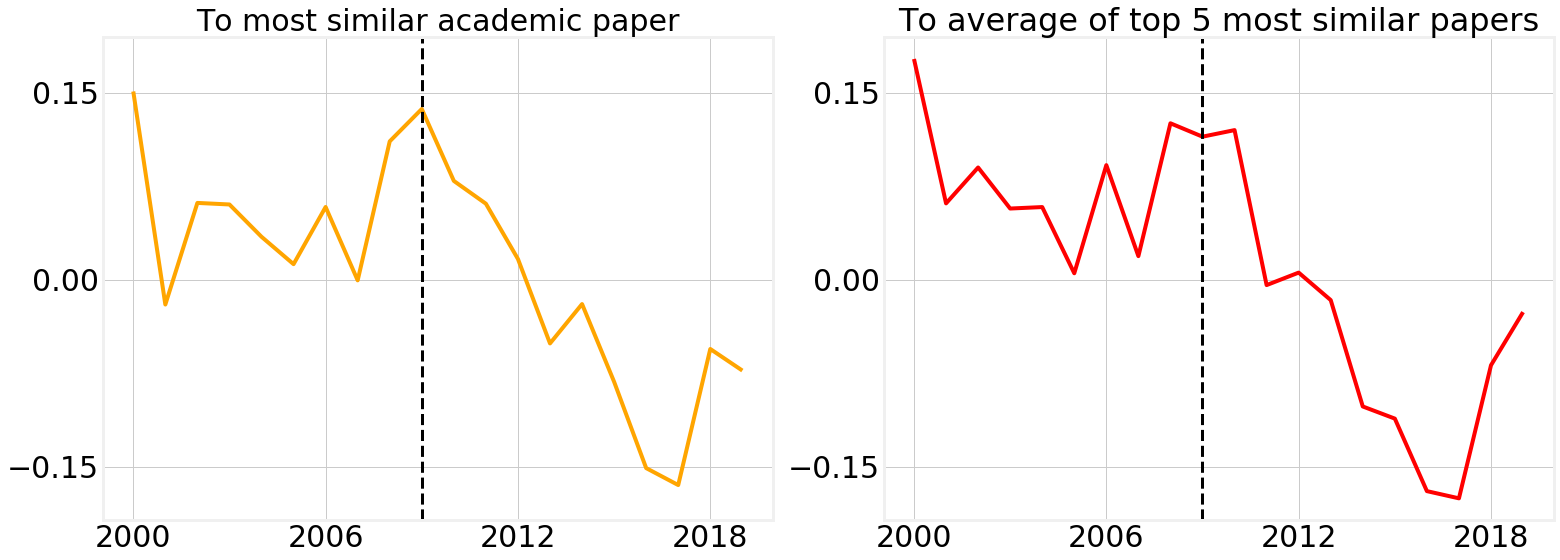

In [21]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(22,8),facecolor='white')

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid(shape=(1,2), loc=(0,1), colspan=1, sharey=ax1)

for ax in [ax1, ax2]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    #ax.grid(False)
    ax.set_facecolor('white')

top    = sims_top_df.groupby(['year']).mean()["distance_std"]
ave    = sims_ave_df.groupby(['year']).mean()["distance_std"]

ax1.plot(top, color="orange")
ax1.set_title("To most similar academic paper",fontsize=30)

ax2.plot(ave, color="red")
ax2.set_title("To average of top 5 most similar papers",fontsize=32)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+9

ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')

plt.tight_layout()
plt.savefig('cosine.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

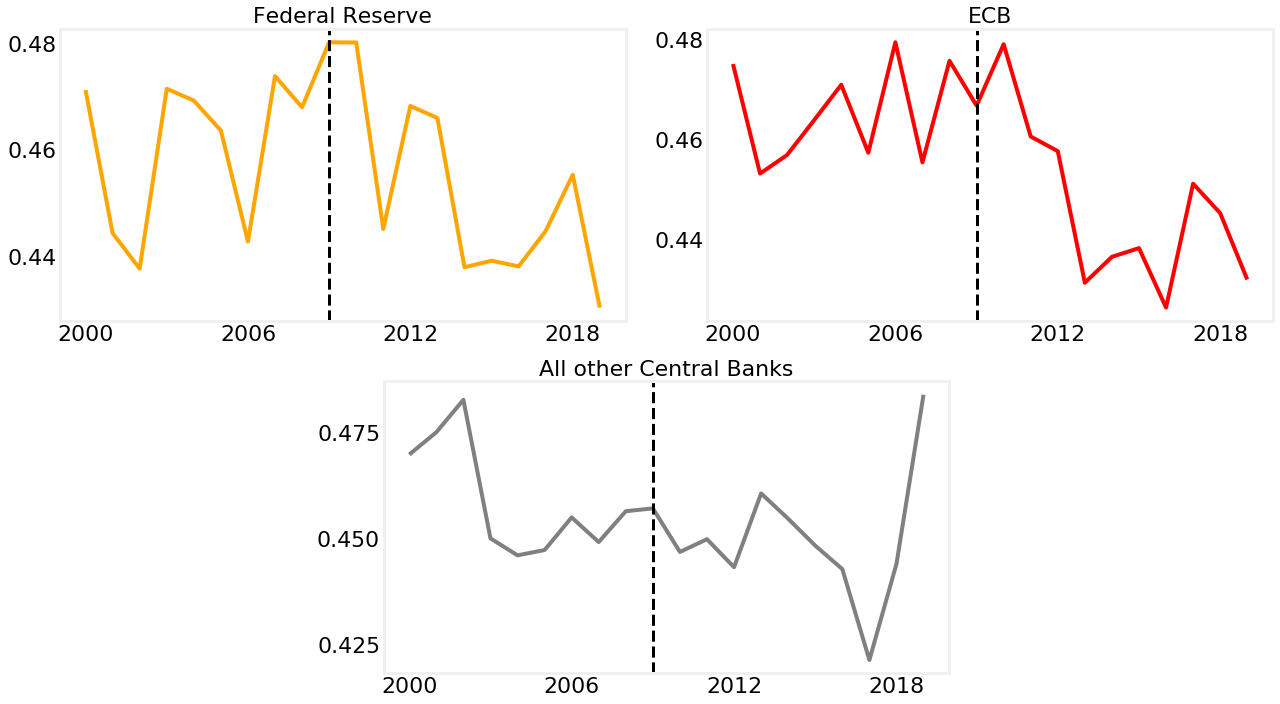

In [22]:
sims_ave = pd.DataFrame(sims_ave)
sims_ave['year'] = all_cb_data.Year
sims_ave['CB'] = all_cb_data.Central_Bank

fig = plt.figure(figsize=(18,10),facecolor='white')

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,2), colspan=2)
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,1), colspan=2)

for ax in [ax1, ax2, ax3]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    ax.grid(False)
    ax.set_facecolor('white')

fed    = sims_ave[(sims_ave.CB == 'US')].groupby(['year']).mean()
ecb    = sims_ave[(sims_ave.CB == 'ECB')].groupby(['year']).mean()
others = sims_ave[sims_ave.CB.isin(['BoE','BoC','RBA','RBNZ','BoJ','Norges','Riksbank'])].groupby(['year']).mean()

ax1.plot(fed, color="orange")
ax1.set_title("Federal Reserve",fontsize=22)

ax2.plot(ecb, color="red")
ax2.set_title("ECB",fontsize=22)

ax3.plot(others, color="grey")
ax3.set_title("All other Central Banks",fontsize=22)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+9

ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax3.axvline(gfc,ls='--',c='k',lw=3,label='test start')

plt.tight_layout()
plt.savefig('cosine_ave.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()